In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import stats
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression


## DATA CLEANING

In [5]:
df = pd.read_csv("usa_00001.csv.gz")
cross_walk = pd.read_csv("PPHA_30545_MP01-Crosswalk.csv")
df_merge = df.merge(cross_walk, how='left', left_on='EDUCD', right_on='educd')
df_merge.drop(columns='educd', inplace=True)
df_merge.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,...,HISPAN,HISPAND,EDUC,EDUCD,EMPSTAT,EMPSTATD,INCWAGE,VETSTAT,VETSTATD,educdc
0,2023,202301,427,2023010020774,1134.0,2023000004271,280301,4,1,1134.0,...,0,0,6,63,1,10,20000,1,11,12.0
1,2023,202301,1723,2023010082405,5994.0,2023000017231,140301,4,1,5994.0,...,0,0,7,71,1,10,5500,1,11,14.0
2,2023,202301,3829,2023000009784,23004.0,2023000038291,60001,1,1,23004.0,...,0,0,6,63,1,10,50000,1,11,12.0
3,2023,202301,3991,2023000021410,11664.0,2023000039911,140101,1,1,11502.0,...,0,0,6,63,1,10,45000,2,20,12.0
4,2023,202301,3991,2023000021410,11664.0,2023000039911,140101,1,2,10368.0,...,0,0,10,101,1,10,80000,1,11,16.0


In [6]:
# high school degree with 0 and 1 value
df_merge["hsdip"] = df_merge["EDUCD"].isin([62,63,64,65,70,71,80,81,82,83,90,100]).astype(int)

# college degree dummy variable
df_merge["coldip"] = ((df_merge["educdc"]>=16)&(df_merge["EDUCD"] !=100)).astype(int)

# if individual is white
df_merge["white"] = (df_merge["RACE"] == 1).astype(int)

# if individual is black
df_merge["black"] = (df_merge["RACE"] == 2).astype(int)

# if is Hispanic origin
df_merge["hispanic"] = (df_merge["HISPAN"] != 0).astype(int)

# if married dummy variable
df_merge["married"] = ((df_merge["MARST"] ==1) | (df_merge["MARST"] == 2)).astype(int)

# if female dummy variable
df_merge["female"] = (df_merge["SEX"] == 2).astype(int)

# if veteran dummy variable
df_merge["vet"] = (df_merge["VETSTAT"] == 2).astype(int)

In [8]:
# interaction term between high school diploma and educdc
df_merge["hsdip_educdc"] = df_merge["hsdip"] * df_merge["educdc"]

# interaction term between college diploma and educdc
df_merge["coldip_educdc"] = df_merge["coldip"] * df_merge["educdc"]

In [9]:
# age squared variable
df_merge["age_squared"] = df_merge["AGE"] **2
# df_merge[['AGE',"age_squared"]].head()

# natural log of incwage
df_merge = df_merge[df_merge["INCWAGE"]>0]
df_merge["log_wage"] = np.log(df_merge["INCWAGE"])

## DATA ANALYSIS

### OLS MODEL

#### Descriptive statistics of each variable

In [12]:
full_df = df_merge.copy()
selected_variables = ["YEAR","INCWAGE","log_wage","educdc","female","AGE","age_squared","white","black","hispanic","married","NCHILD","vet","hsdip","coldip","hsdip_educdc","coldip_educdc"]
full_df = full_df[selected_variables]
full = full_df.describe()
print(full)

         YEAR        INCWAGE     log_wage       educdc       female  \
count  8679.0    8679.000000  8679.000000  8679.000000  8679.000000   
mean   2023.0   70930.097938    10.697986    14.327227     0.485655   
std       0.0   83145.834339     1.078228     2.963376     0.499823   
min    2023.0      10.000000     2.302585     0.000000     0.000000   
25%    2023.0   28000.000000    10.239960    12.000000     0.000000   
50%    2023.0   50000.000000    10.819778    14.000000     0.000000   
75%    2023.0   85000.000000    11.350407    16.000000     1.000000   
max    2023.0  770000.000000    13.554146    22.000000     1.000000   

               AGE  age_squared        white        black     hispanic  \
count  8679.000000  8679.000000  8679.000000  8679.000000  8679.000000   
mean     41.779583  1921.735108     0.651458     0.081346     0.164305   
std      13.274858  1119.564228     0.476536     0.273381     0.370573   
min      18.000000   324.000000     0.000000     0.000000     0.

#### Scatter plot of log wage and education

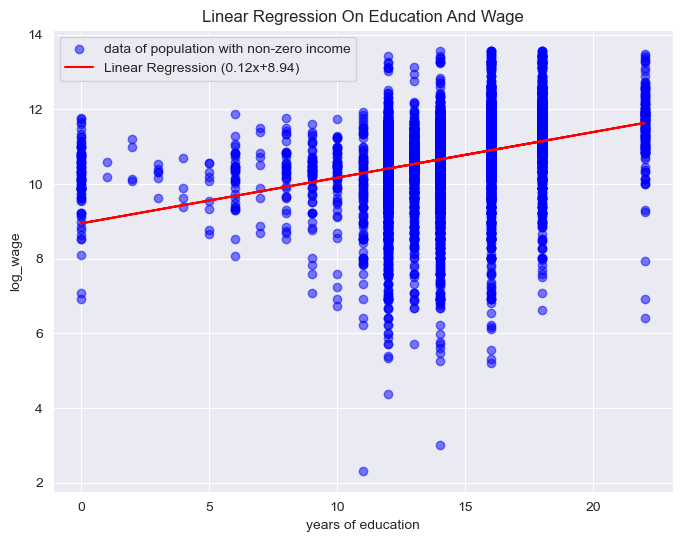

In [13]:
plt.figure(figsize=(8,6))
x = full_df["educdc"]
y = full_df["log_wage"]
plt.scatter(x,y, color = 'blue', alpha = 0.5, label = 'data of population with non-zero income')

# add regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x,m*x+b, color = 'red', label = f'Linear Regression ({m:.2f}x+{b:.2f})')

# labels and legend
plt.xlabel('years of education')
plt.ylabel('log_wage')
plt.legend()
plt.title('Linear Regression On Education And Wage')
plt.show()

In [14]:
# multiple linear regression
x=full_df[["educdc","female","AGE","age_squared","white","black","hispanic","married","vet"]]
y=full_df["log_wage"]

# add intercept
x = sm.add_constant(x)

# fit regression
model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     399.7
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:13:17   Log-Likelihood:                -11462.
No. Observations:                8679   AIC:                         2.294e+04
Df Residuals:                    8669   BIC:                         2.301e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.0998      0.111     54.964      

#### Interpretation of the OLS Model

The OLS model has R^2 = 0.293, which means 29.3% of the variation in log wages has been explained by the model.\
Holding all other variables fixed, we want to maximize 0.1475*age - 0.0015*(age^2). Using derivative, we want 0.1475 - 0.003*age = 0. age = 49.17\
    The model predict an individual will achieve the highest wage at age 49.\
The coefficient of educdc is 0.106, suggestion one additional year of education will increase the expected wages in 10.6%., holding all other variables fixed.
The coefficient of the female dummy variable is negative, which means female has lower wage than male.\
The coefficient of white is 0.0002, suggesting white people have expected log wage 0.0002 higher than non-white people. The p-value is 0.995 > 0.05. We fail to reject the null hypothesis (coefficient = 0). The coefficient is not statistically significant.\
    The coefficient of black is -0.2085, suggesting black people have expected log wage 0.2085 lower than non-black people. The p-value is 0.000 < 0.05. We reject the null hypothesis in favor of the alternative, coefficient is not equal to 0. The coefficient is statistically significant.


## GROUPED REGRESSION MODEL

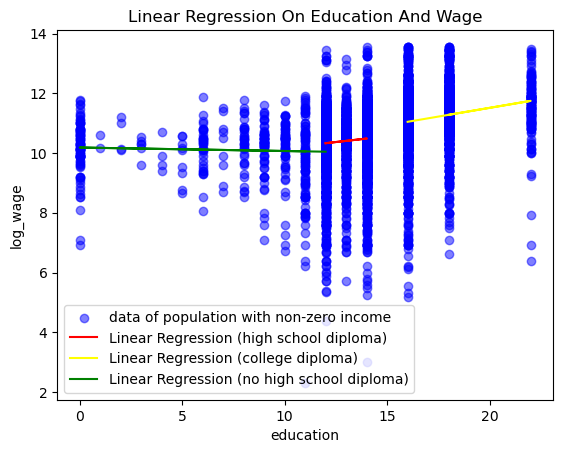

In [14]:
# subset the three groups
high_school_population = full_df[full_df["hsdip"]==1]
college_population = full_df[full_df["coldip"]==1]
no_high_school_population = full_df[(full_df["hsdip"]==0)&(full_df["coldip"]==0)]

# regression on high school population
high_school_x = high_school_population["educdc"]
high_school_y = high_school_population["log_wage"]
high_school_coef, high_school_inter = np.polyfit(high_school_x, high_school_y, 1)

# regression on college population
college_x = college_population["educdc"]
college_y = college_population["log_wage"]
college_coef, college_inter = np.polyfit(college_x, college_y, 1)

# regression on non high school population
no_high_school_x = no_high_school_population["educdc"]
no_high_school_y = no_high_school_population["log_wage"]
no_high_school_coef, no_high_school_inter = np.polyfit(no_high_school_x, no_high_school_y, 1)

# define x, y for all population
x = full_df["educdc"]
y = full_df["log_wage"]

# plot the scatter plot
plt.scatter(x,y, color = 'blue', alpha = 0.5, label = 'data of population with non-zero income')

# adding the regression lines
plt.plot(high_school_x, high_school_coef*high_school_x+high_school_inter, color = 'red', label = 'Linear Regression (high school diploma)')
plt.plot(college_x, college_coef*college_x+college_inter, color = 'yellow', label = 'Linear Regression (college diploma)')
plt.plot(no_high_school_x, no_high_school_coef*no_high_school_x+no_high_school_inter, color = 'green', label = 'Linear Regression (no high school diploma)')
plt.xlabel('education')
plt.ylabel('log_wage')
plt.legend()
plt.title('Linear Regression On Education And Wage')
plt.show()



We can have separate regressions on the three distinct groups: individuals with no high school diploma, a high school diploma, and a college degree. The separate fit may give a better result on predicting wage return on people with different levels of education.

In [16]:
# differential intercept for college diploma
x= full_df[["educdc", "coldip", "coldip_educdc","female","AGE","age_squared","white","black","hispanic","married","NCHILD","vet"]]
y = full_df["log_wage"]

# adding intercept
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     327.5
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:13:29   Log-Likelihood:                -11345.
No. Observations:                8679   AIC:                         2.272e+04
Df Residuals:                    8666   BIC:                         2.281e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.8172      0.129     53.040

To estimate the effect of attending college on wage return, I include two more variables: a college degree dummy variable with 1 representing having the degree and 0 as not having the degree; an interactive term of years of education and whether having the degree.
The first variable will estimate how owning college degree will impact wage, holding years of education constant. The second variable will estimate the effect of a college degree on wages changes as the years of education increase. This model allows for the possibility that the returns to education differ between degree holders and non-holders.

The coefficient for college degree is -0.0969. Holding everything else constant, having a college degree will decrease wage by 9.69%. The p-value is 0.611>0.05, suggesting the coefficient is not statistically significant.\
The coefficient for the interactive term is 0.0334. Holding everything else constant, an additional year of education increases wages by 3.34% more for individuals with a college degree compared to those without. The p-value is 0.005<0.05, suggesting the coefficient is statistically significant.


In [17]:
betas = model.params
female_edu_12 = np.array([1,12,0,0,1,22,22**2,0,0,0,0,0,0])
female_edu_16 = np.array([1,16,1,16,1,22,22**2,0,0,0,0,0,0])

# calculate log wage regarding degrees
log_wage_12 = np.dot(female_edu_12,betas)
log_wage_16 = np.dot(female_edu_16,betas)

# convert log wage to wages
wage_12 = np.exp(log_wage_12)
wage_16 = np.exp(log_wage_16)
# print("Predicted wage for female graduating high school is {wage_12:.2f}".format(wage_12=wage_12))
# print("Predicted wage for female graduating college is {wage_16:.2f}".format(wage_16=wage_16))

In [34]:
difference_wage = wage_16 - wage_12
percentage_difference_wage = (difference_wage/wage_12)*100
print(difference_wage)
print(percentage_difference_wage)


10549.52038000918
84.92003314101028


### Interpretation of The Grouped Regression Model

The model shows a significant impact of a college degree on wages. The individual with a college degree will have 10549.52 more predicted wage than without a college degree. The wage increase by 84.92% is obtaining a college degree. This model explains 31.2% of the variation in log wages. The model in question 3 explained 29.3%. This new model explains more of the variation in log wages. This finding supports expanding access to higher education.
The 95% confidence interval for year of education is [0.033, 0.055]. It suggests a stable, positive effect of education on wages. However, the interval for coldip is [-0.471, 0.277] which includes zero, meaning we cannot confidently conclude that having a college degree alone provides an additional wage boost beyond the extra years of education. For the interactive effect of years of education and college degree, the 95% confident interval is [0.010, 0.057] which is also above 0. It suggests that having a college degree will lead to higher wage with years of education growth.

### Limitations

However, selection bias and omitted variables need to be considered. One key limitation is that we didn’t account for work experience, which could bias our results. People who skip college and start working earlier gain experience that might boost wages, meaning we might overestimate the effect of a degree. Other factors like occupation and field of study also matter but aren’t included in our model. Selection bias is another issue—those who attend college are often different from those who don’t in terms of ambition, family background, and resources. This means the observed college wage premium may not fully reflect a causal effect. Simply expanding access may not have the expected impact for everyone. I’d advise the President to pursue the legislation, but with these limitations in mind. Expanding college access is important, but additional policies—like vocational training, financial aid, and career guidance—should be considered to maximize impact.

## Cubic Spline Model

In [42]:
x_age = full_df[["AGE"]]
x_else = full_df[["educdc", "female", "white", "black",
                   "hispanic", "married", "NCHILD", "vet"]]
y = full_df["log_wage"]

# Define knots at ages 18 and 65
knots = np.array([18, 65]).reshape(-1, 1)

# Use cubic splines (degree=3) SplineTransformer only store information doesn't perform anything
spline_transformer = SplineTransformer(degree=3, knots=knots, include_bias=False)

# Transform AGE into spline basis functions
# SplineTransformer(...).fit_transform(training data)这时候再call fit_transform function
# store in n*5 matrix [x, x^2, x^3, (x-knot1)^3, (x-knot2)^3]
X_splines = spline_transformer.fit_transform(x_age)

# Combine spline features with other predictors, hstack (horizontal stack )
# combine columns -> n*(5 + k_variables) matrix
X = np.hstack([X_splines, x_else])

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print intercept and coefficients
print("Intercept:", model.intercept_)

# Generate column names for the transformed spline features
spline_columns = [f"spline_{i}" for i in range(X_splines.shape[1])]   #traverse each spline and make names splines_{i}
all_columns = spline_columns + list(x_else.columns)  # convert panda index to python list

coefficients = pd.Series(model.coef_, index=all_columns)
print("Coefficients:")
print(coefficients)

# Calculate R² and Adjusted R²
r_squared = model.score(X, y)

n = len(y)
p = X.shape[1]  # Total number of predictors
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

print("Adjusted R-squared:", adjusted_r_squared)

Intercept: 13.639907329379492
Coefficients:
spline_0   -21.839265
spline_1    -1.569960
spline_2    -5.797012
educdc       0.102700
female      -0.398431
white       -0.001331
black       -0.203193
hispanic    -0.070186
married      0.186538
NCHILD      -0.035319
vet          0.018201
dtype: float64
Adjusted R-squared: 0.3036983974865053


The cubic spline model increase the adjusted R^2 from 0.293 to 0.304, which is expected because splines introduce more flexibility by allowing different relationships at different age ranges.
However, the increase in R² is small because the knots at 18 and 65 are located at the boundaries of the age distribution, meaning most of the data remains unaffected by the additional flexibility. As a result, the model does not gain much predictive power beyond the original quadratic specification (AGE and AGE²).
If we had chosen more interior knots (e.g., around the median or quartiles of the age distribution), we might have captured more complex patterns in the data, potentially leading to a larger R² improvement.

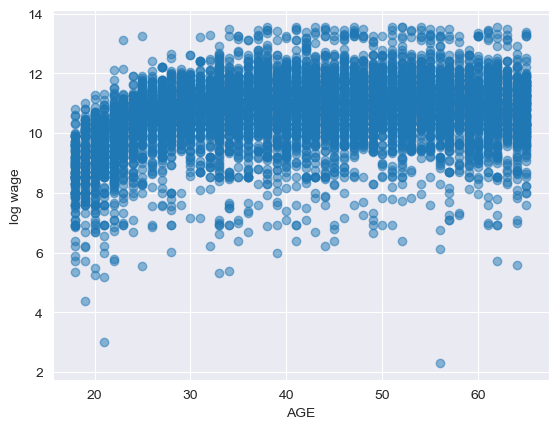

In [18]:
plt.scatter(full_df["AGE"], full_df["log_wage"], alpha = 0.5)
plt.xlabel('AGE')
plt.ylabel('log wage')
plt.show()

### Model Tuning

In [120]:
# Define knots at ages 24 and 55
knots_close = np.array([24, 55]).reshape(-1, 1)

# Use cubic splines (degree=3)
spline_transformer_close = SplineTransformer(degree=3, knots=knots_close, include_bias=False)

# Transform AGE into spline basis functions
X_splines_close = spline_transformer_close.fit_transform(x_age)

# Combine spline features with other predictors
X_close = np.hstack([X_splines_close, x_else])

# Fit the linear regression model
model_close = LinearRegression()
model_close.fit(X_close, y)

# Print intercept and coefficients
print("Intercept:", model_close.intercept_)

# Generate column names for the transformed spline features
spline_columns_close = [f"spline_{i}" for i in range(X_splines_close.shape[1])]
all_columns_close = spline_columns_close + list(x_else.columns)

coefficients_close = pd.Series(model_close.coef_, index=all_columns_close)

# Calculate R² and Adjusted R²
r_squared_close = model_close.score(X_close, y)

n = len(y)
p_close = X_close.shape[1]  # Total number of predictors
adjusted_r_squared_close = 1 - ((1 - r_squared_close) * (n - 1)) / (n - p_close - 1)

print("Adjusted R-squared:", adjusted_r_squared_close)

Intercept: 12.960369403444096
Adjusted R-squared: 0.27904412901003395


In [112]:
knots_test = np.array([18, 35, 64]).reshape(-1, 1)

# Use cubic splines (degree=3)
spline_transformer_test = SplineTransformer(degree=3, knots=knots_test, include_bias=False)

# Transform AGE into spline basis functions
X_splines_test = spline_transformer_test.fit_transform(x_age)

# Combine spline features with other predictors
X_test = np.hstack([X_splines_test, x_else])

# Fit the linear regression model
model_test = LinearRegression()
model_test.fit(X_test, y)

# Calculate R² and Adjusted R²
r_squared_test = model_test.score(X_test, y)

n = len(y)
p_test = X_test.shape[1]  # Total number of predictors
adjusted_r_squared_test = 1 - ((1 - r_squared_test) * (n - 1)) / (n - p_test - 1)

print("Adjusted R-squared:", adjusted_r_squared_test)

Adjusted R-squared: 0.3134920333881476


Placing three knots at 18,35,64, the model gets the optimal R^2 0.3135. After looking at the graph, we can see the wage increase from 18 - mid-thirty and stay pretty stable till late 50. After trying several different knots around this range, I found putting knots at 18, 35, 64 give the biggest R^2.

### Using Cubic Spline Model for Wage Prediction

In [125]:
# Define AGE values to predict
ages = np.array([[17], [50]])  # 2D array required for SplineTransformer

# Transform AGE using the fitted spline model (knots at 24, 55)
# transform to match basis function x, x^2, x^3, (x-knot1)^3, (x-knot2)^3
X_splines_pred = spline_transformer_close.transform(ages)  # Use the same transformer from model training

# Define other predictors (same for both individuals)
X_other_pred = np.array([
    [16, 1, 0, 0, 0, 0, 0, 0],
    [16, 1, 0, 0, 0, 0, 0, 0]
])

# Combine transformed AGE splines with other predictors
X_pred = np.hstack([X_splines_pred, X_other_pred])

# Compute predicted log wages using dot product
log_wage_pred = model_close.intercept_+ np.dot(X_pred, coefficients_close.to_numpy())

# Convert log wages to actual wages
wage_pred = np.exp(log_wage_pred)

# Print results
print(f"Predicted wage for a female (age 17, college diploma): ${wage_pred[0]:.2f}")
print(f"Predicted wage for a female (age 50, college diploma): ${wage_pred[1]:.2f}")


Predicted wage for a female (age 17, college diploma): $18763.37
Predicted wage for a female (age 50, college diploma): $46067.97


C:\Users\beryl\anaconda3\envs\new_evm\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


In our model, the predicted wages for a female at ages 17 and 50 differ due to the cubic spline transformation with knots at ages 24 and 55. The spline regression divides the age range into different regions, each with its own function. The 17-year-old follows the equation for the pre-24 age group, while the 50-year-old follows the equation for the 24–55 age range. Since spline regression allows for different slopes in different regions, wages change at different rates in each age range, leading to distinct predictions.